In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from annoy import AnnoyIndex

data = pd.read_csv('./creditcard.csv')

In [3]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [4]:
for i, row in data.iterrows():
    break

In [10]:
len(row.values[:-1])

30

In [2]:
print(f'Dataset Length is: {len(data)}')

Dataset Length is: 284807


In [11]:
G = nx.Graph()

# Add nodes for cardholders and transactions
for ith, row in data.iterrows():
    transaction_node = f"cardholder_{ith}"
    G.add_node(transaction_node, type='transaction', amount=row['Amount'], label=row['Class'])

f = 30
amount_index = AnnoyIndex(f, 'angular')

for i, row in data.iterrows():
    amount_index.add_item(i, row.values[:-1])

amount_index.build(100)
# sim_threshold=5

for i in range(len(data)):
    neighbors = amount_index.get_nns_by_item(i, 1, include_distances=True)
    for neighbor_index, dist in zip(neighbors[0], neighbors[1]):
        if i!=neighbor_index:
            transaction_node_i = f"cardholder_{i}"
            transaction_node_j = f"cardholder_{neighbor_index}"
            G.add_edge(transaction_node_i, transaction_node_j, weight=dist)


print(f'Number of nodes: {G.number_of_nodes()}')
print(f'Number of edges: {G.number_of_edges()}')

Number of nodes: 284807
Number of edges: 274262


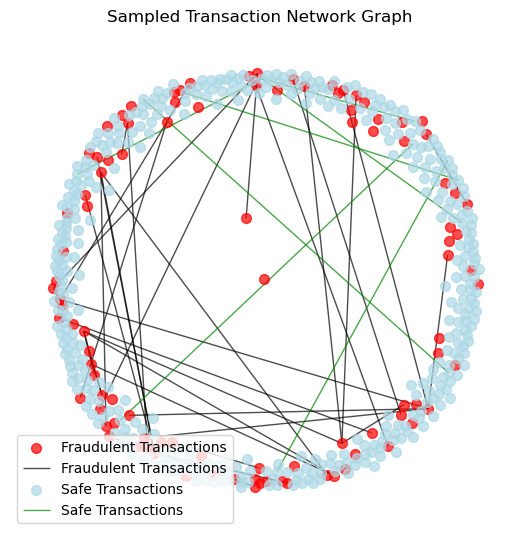

In [26]:
class_1_nodes = [u for u, data in G.nodes(data=True) if data['label']==1][:100]
class_0_nodes = [u for u, data in G.nodes(data=True) if data['label']==0][:400]


G_subsampled = G.subgraph(class_0_nodes+class_1_nodes).copy()
G_class_1 = G.subgraph(class_1_nodes).copy()
G_class_0 = G.subgraph(class_0_nodes).copy()

plt.figure(figsize=(5, 5))
pos=nx.spring_layout(G_subsampled, seed=42)
nx.draw(G_class_1, pos, with_labels=False, node_size=50, node_color='red', edge_color='black', alpha=0.7, label="Fraudulent Transactions")
nx.draw(G_class_0, pos, with_labels=False, node_size=50, node_color='lightblue', edge_color='green', alpha=0.7, label="Safe Transactions")
plt.title('Sampled Transaction Network Graph')
plt.legend(loc='lower left')
plt.show()


In [33]:
k = G.nodes(data=True)

In [36]:
class_1_nodes

['cardholder_541',
 'cardholder_623',
 'cardholder_4920',
 'cardholder_6108',
 'cardholder_6329',
 'cardholder_6331',
 'cardholder_6334',
 'cardholder_6336',
 'cardholder_6338',
 'cardholder_6427',
 'cardholder_6446',
 'cardholder_6472',
 'cardholder_6529',
 'cardholder_6609',
 'cardholder_6641',
 'cardholder_6717',
 'cardholder_6719',
 'cardholder_6734',
 'cardholder_6774',
 'cardholder_6820',
 'cardholder_6870',
 'cardholder_6882',
 'cardholder_6899',
 'cardholder_6903',
 'cardholder_6971',
 'cardholder_8296',
 'cardholder_8312',
 'cardholder_8335',
 'cardholder_8615',
 'cardholder_8617',
 'cardholder_8842',
 'cardholder_8845',
 'cardholder_8972',
 'cardholder_9035',
 'cardholder_9179',
 'cardholder_9252',
 'cardholder_9487',
 'cardholder_9509',
 'cardholder_10204',
 'cardholder_10484',
 'cardholder_10497',
 'cardholder_10498',
 'cardholder_10568',
 'cardholder_10630',
 'cardholder_10690',
 'cardholder_10801',
 'cardholder_10891',
 'cardholder_10897',
 'cardholder_11343',
 'cardholde

In [38]:
k['cardholder_30473'].get('label')

1.0

In [51]:
for u in G.nodes(data=True):
    break

In [53]:
u

('cardholder_0', {'type': 'transaction', 'amount': 149.62, 'label': 0.0})

In [48]:
import torch

y = torch.tensor([data['label'] for u, data in G.nodes(data=True)], dtype=torch.long)

In [55]:
x = torch.tensor([[data['amount']] for u, data in G.nodes(data=True)], dtype=torch.float)
x.shape

torch.Size([284807, 1])

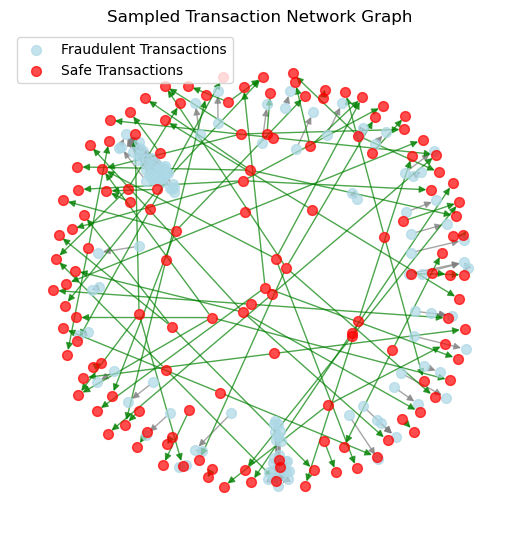

In [6]:
# edges_class1 = [(u,v) for u, v, data in G.edges(data=True) if data.get('label')==1][0:100]
# edges_class0 = [(u,v) for u, v, data in G.edges(data=True) if data.get('label')==0][0:100]

# G_class_1 = G.edge_subgraph(edges_class1).copy()
# G_class_0 = G.edge_subgraph(edges_class0).copy()
# plt.figure(figsize=(5, 5))
# pos1=nx.spring_layout(G_class_1, seed=42)
# pos0=nx.spring_layout(G_class_0, seed=42)
# nx.draw(G_class_1, pos1, with_labels=False, node_size=50, node_color='lightblue', edge_color='gray', alpha=0.7, label="Fraudulent Transactions")
# nx.draw(G_class_0, pos0, with_labels=False, node_size=50, node_color='red', edge_color='green', alpha=0.7, label="Safe Transactions")
# plt.title('Sampled Transaction Network Graph')
# plt.legend()
# plt.show()


In [16]:
import torch
from torch_geometric.data import Data

nodes = list(G.nodes())
node_map = {node: i for i, node in enumerate(nodes)}

edge_index = torch.tensor([[node_map[u], node_map[v]] for u,v in G.edges()], dtype=torch.long).t().contiguous()
edge_attr = torch.tensor([G[u][v]['amount'] for u,v in G.edges], dtype=torch.float).view(-1,1)
y = torch.tensor([G[u][v]['label'] for u,v in G.edges], dtype=torch.long)
x = torch.zeros((len(nodes),1),dtype=torch.float)
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

In [ ]:
from torch_geometric.nn import GCNConv, global_mean_pool

class GNNModel(torch.nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(in_channels=1, out_channels=16)
        self.conv2 = GCNConv(in_channels=16, out_channels=32)
        self.fc = torch.nn.Linear(32,2)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_attr)
        x = torch.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = torch.relu(x)
        x = global_mean_pool(x, data.batch)  # Pooling step
        x = self.fc(x)
        return x
    


In [ ]:
# Initialize model, loss, and optimizer
model = GNNModel()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Track and plot training loss
losses = []

for epoch in range(20):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(range(1, 21), losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Evaluation
model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred == data.y).sum().item()
    accuracy = correct / len(data.y)
    print(f'Accuracy: {accuracy:.2f}')